## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df=pd.read_csv('ab_data.csv')

In [3]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [19]:
df.iloc[2893]

user_id                             773192
timestamp       2017-01-14 02:55:59.590927
group                            treatment
landing_page                      new_page
converted                                0
Name: 2893, dtype: object

b. Use the below cell to find the number of rows in the dataset.

In [4]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [5]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [6]:
df['converted'].sum()/df.shape[0]

0.11965919355605512

In [7]:
df['group'].value_counts()

treatment    147276
control      147202
Name: group, dtype: int64

e. The number of times the `new_page` and `treatment` don't line up.

In [8]:
df.query('group!="treatment" and landing_page=="new_page"').count()[0]+\
df.query('group=="treatment" and landing_page!="new_page"').count()[0]

3893

In [9]:
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

3893

f. Do any of the rows have missing values?

In [10]:
df.isnull().sum()
# 无缺失值

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [11]:
x=df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].index.values

In [12]:
df2=df.drop(index=x,axis=0)

In [13]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [14]:
df2.shape

(290585, 5)

In [15]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [16]:
df2[df2['user_id'].duplicated()==True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [17]:
df2.query('user_id=="773192"')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [18]:
df2.drop(index=2893,axis=0,inplace=True)

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [19]:
df2['converted'].sum()/df2.shape[0]

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [20]:
df2.query('group=="control"').converted.sum()/df2.query('group=="control"').count()[0]

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [21]:
df2.query('group=="treatment"').converted.sum()/df2.query('group=="treatment"').count()[0]

0.11880806551510564

d. What is the probability that an individual received the new page?

In [22]:
df2.query('landing_page=="new_page"').count()[0]/df2.shape[0]

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**在用户打开新旧网页概率接近相等的情况，control组的用户转化率略高于treatment组，所以无法证实treatment组带来更高的转化率。**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**$H_{0}$ : $P_{new}$ <= $P_{old}$**  

**$H_{1}$ : $P_{new}$ > $P_{old}$**  

**a=0.05**


`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [23]:
p_new=df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [24]:
p_old=df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [25]:
n_new=df2.query('landing_page=="new_page"').shape[0]
n_new

145310

d. What is $n_{old}$?

In [26]:
n_old=df2.query('landing_page=="old_page"').shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [27]:
new_page_converted=np.random.binomial(n_new,p_new)


f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [28]:
old_page_converted=np.random.binomial(n_old,p_old)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [29]:
sample_diff=(new_page_converted/n_new)-(old_page_converted/n_old)
sample_diff

0.000211199414710303

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [30]:
p_diffs=[]
for _ in range(10000):
    new_page_converted1=np.random.binomial(n_new,p_new)
    old_page_converted1=np.random.binomial(n_old,p_old)
    diffs1=(new_page_converted1/n_new)-(old_page_converted1/n_old)
    p_diffs.append(diffs1)

In [31]:
p_diffs=np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

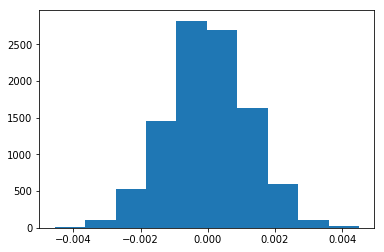

In [32]:
plt.hist(p_diffs);

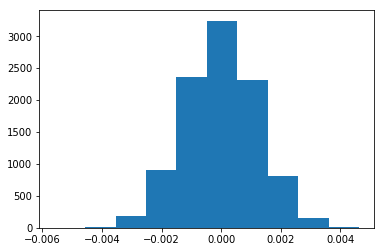

In [33]:
null_mean=0
null_vals=np.random.normal(null_mean,np.std(p_diffs),10000)
plt.hist(null_vals);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [34]:
actual_new_page_converted=df2.query('landing_page=="new_page"')['converted'].value_counts()[1]/\
df2.query('landing_page=="new_page"').shape[0]

In [35]:
actual_old_page_converted=df2.query('landing_page=="old_page"')['converted'].value_counts()[1]/\
df2.query('landing_page=="old_page"').shape[0]

In [36]:
actual_diff=actual_new_page_converted-actual_old_page_converted

In [37]:
p=(null_vals>actual_diff).mean()
p

0.9023

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**p值=0.91,接近1，所以我们无法拒绝原假设，即无法拒绝新旧网页转化率一样的假设。**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [38]:
import statsmodels.api as sm

convert_old = df2.query('landing_page=="old_page" and converted==1').shape[0]
convert_new = df2.query('landing_page=="new_page" and converted==1').shape[0]
n_old = df2.query('landing_page=="old_page"').shape[0]
n_new = df2.query('landing_page=="new_page"').shape[0]


/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [39]:
z_score, p_value = sm.stats.proportions_ztest([convert_old,convert_new], [n_old, n_new],alternative='smaller')
z_score, p_value

(1.3109241984234394, 0.9050583127590245)

In [40]:
z_score, p_value

(1.3109241984234394, 0.9050583127590245)

In [41]:
from scipy.stats import norm
norm.cdf(z_score), norm.ppf(1-0.05)

(0.9050583127590245, 1.6448536269514722)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**z_score=1.31，小于置信区间的末端值1.64，p值大于I类错误阈值，所以我们无法拒绝原假设，新旧网页的转化率差异不明显**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**因变量“网页转化率”是区间为[0,1]的概率预测，所以再这里应该选择逻辑回归。**


b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [42]:
import statsmodels.api as sm

In [43]:
df2[['control','treatment']]=pd.get_dummies(df2['group'])
df2[['new_page','old_page']]=pd.get_dummies(df2['landing_page'])
df2['intercept']=1
df2.head()

,user_id,timestamp,group,landing_page,converted,control,treatment,new_page,old_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,0,1,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,0,1,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0,1,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,0,1,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [44]:
logit_mod=sm.Logit(df2['converted'],df2[['intercept','new_page']])
results=logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [45]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2018-06-19 14:41 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
new_page     -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

- 该回归方程中的p值与Part II中的p值含义是不一样的，以下是该回归方程的零假设和备择假设
- **H0:p_new-p_old=0**
- **H1:p_new-p_old!=0**
- 在该回归方程中，new_page与old_page比较之后的差异系数的p值为0.19，大于通常alpha值0.05，表示其系数不为零不具有统计显著性，无法拒绝原假设，new_page与old_page的差异为零的可能性较大。

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

- 参考其他解释变量可能会使回归模型的拟合效果更好，但是另外一方面，添加更多解释变量的同时，
- 也需要考虑多重共线性的问题，即线性回归模型中的解释变量之间由于存在精确相关关系或高度相关关系而使模型估计失真或难以估计准确。
- 对于多重共线性的问题，可以计算方差膨胀因子，VIF越大，显示共线性越严重。
- 经验判断方法表明：当0<VIF<10，不存在多重共线性；当10≤VIF<100，存在较强的多重共线性；当VIF≥100，存在严重多重共线性。

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [46]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [47]:
### Create the necessary dummy variables
df_new.head()

,country,timestamp,group,landing_page,converted,control,treatment,new_page,old_page,intercept
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,0,1,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,0,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,0,1,1,0,1


In [48]:
df_new['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [49]:
### Fit Your Linear Model And Obtain the Results
df_new['intercept']=1
df_new[['CA','UK','US']]=pd.get_dummies(df_new['country'])

In [50]:
logit_mod2=sm.Logit(df_new['converted'],df_new[['intercept','UK','US']])
results2=logit_mod2.fit()
results2.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2018-06-19 14:41 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0375    0.0260  -78.3639  0.0000  -2.0885  -1.9866
UK             0.0507    0.0284    1.7863  0.0740  -0.0049   0.1064
US             0.0408    0.0269    1.5178  0.1291  -0.0119   0.0935
==================================================================

"""

**UK、US与CA比较之后差异的系数的p都大于通常的alpha值0.05的水平，因此country变量对converted的影响不具有统计显著性。**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [51]:
df_new[['new_page','old_page']]=pd.get_dummies(df_new['landing_page'])

In [52]:
df_new['new_page_UK']=df_new['new_page']*df_new['UK']
df_new['new_page_US']=df_new['new_page']*df_new['US']

In [53]:
logit_mod3=sm.Logit(df_new['converted'],df_new[['intercept','UK','US','new_page','new_page_UK','new_page_US']])
results3=logit_mod3.fit()
results3.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2018-06-19 14:41 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
US             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
new_page      -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
new_page_UK    0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
new_page_US    0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
==================================================================

"""

***从个变量系数的P值都大于通常alpha值0.05的结果来看，该模型的的的各变量对conversion的影响不具有显著统计性。***

<a id='conclusions'></a>
## Conclusions

Congratulations on completing the project! 

### Gather Submission Materials

Once you are satisfied with the status of your Notebook, you should save it in a format that will make it easy for others to read. You can use the __File -> Download as -> HTML (.html)__ menu to save your notebook as an .html file. If you are working locally and get an error about "No module name", then open a terminal and try installing the missing module using `pip install <module_name>` (don't include the "<" or ">" or any words following a period in the module name).

You will submit both your original Notebook and an HTML or PDF copy of the Notebook for review. There is no need for you to include any data files with your submission. If you made reference to other websites, books, and other resources to help you in solving tasks in the project, make sure that you document them. It is recommended that you either add a "Resources" section in a Markdown cell at the end of the Notebook report, or you can include a `readme.txt` file documenting your sources.

### Submit the Project

When you're ready, click on the "Submit Project" button to go to the project submission page. You can submit your files as a .zip archive or you can link to a GitHub repository containing your project files. If you go with GitHub, note that your submission will be a snapshot of the linked repository at time of submission. It is recommended that you keep each project in a separate repository to avoid any potential confusion: if a reviewer gets multiple folders representing multiple projects, there might be confusion regarding what project is to be evaluated.

It can take us up to a week to grade the project, but in most cases it is much faster. You will get an email once your submission has been reviewed. If you are having any problems submitting your project or wish to check on the status of your submission, please email us at dataanalyst-project@udacity.com. In the meantime, you should feel free to continue on with your learning journey by beginning the next module in the program.